In [19]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [2]:
#https://mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas

def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
X_test = pd.read_csv(path_csv + "ontime_reporting_X_test_unscaled.csv")
y_test = pd.read_csv(path_csv + "ontime_reporting_y_test.csv")

X_test = rm(X_test)
y_test = np.ravel(y_test)

Memory usage of dataframe is 186.84 MB
Memory usage after optimization is: 48.83 MB
Decreased by 73.9%


In [4]:
xgb_class_tuned_ros = joblib.load(path_model + "XGBoost_tuned_ROS.joblib")
y_pred_xgb_tuned_ros = xgb_class_tuned_ros.predict(X_test)
#y_pred_prob_xgb_tuned_ros = xgb_class_tuned_ros.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [19:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [19:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [ ]:
y_diff = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_xgb_tuned_ros})
y_diff['Difference'] = np.where(y_diff['y_test'] == y_diff['y_pred'], 0, 1) #0 means no difference, 1 means a difference
merged_df = X_test.merge(y_diff, left_index=True, right_index=True)

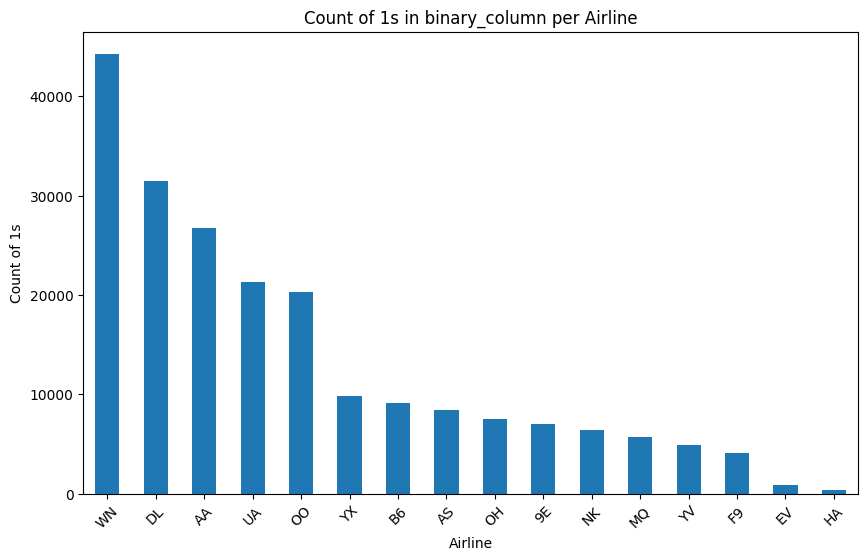

In [25]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("OP_UNIQUE_CARRIER")["Difference"].count()
counts = counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
#plt.title("Count of 1s in binary_column per Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts of prediction errors")
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

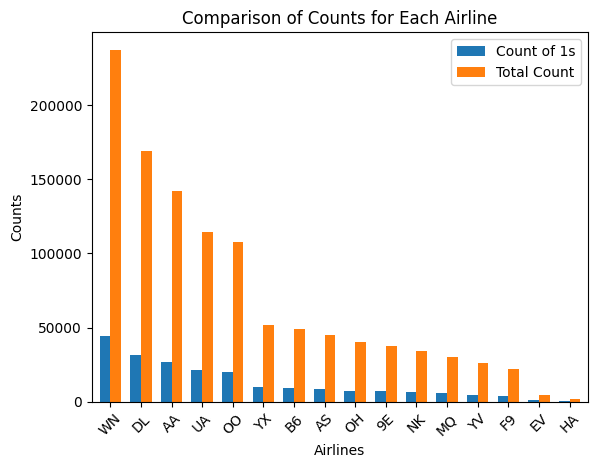

In [27]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("OP_UNIQUE_CARRIER")["Difference"].count()
counts = counts.sort_values(ascending=False)

total_counts = X_test.groupby("OP_UNIQUE_CARRIER").size()

combined_counts = pd.concat([counts, total_counts], axis=1)
combined_counts.columns = ["Count of 1s", "Total Count"]

plt.figure(figsize=(10, 6))
combined_counts.plot(kind="bar", width=0.7)
plt.title("Comparison of Counts for Each Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()